In [2]:
import gym
import tensorflow as tf
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import time

In [3]:
# Create the Cart-Pole game environment
env = gym.make('MountainCar-v0')

def compute_modified_reward(next_state):
    modified_reward = np.square(max(0, next_state[0] + 0.5))
    if next_state[0] >= 0.5: 
        modified_reward += 1.0
    return modified_reward

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


/Users/ashton/other/juniper/env/lib/python2.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
# Environment parameters
state_size = 2
action_size = 3

# Training parameters
train_episodes = 501          # number of episodes to train
max_steps = 200                # max number of step in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_stop = 0.01            # minimum exploration probability 
decay_rate = 0.01            # exponential decay rate for exploration prob

# Q neural network parameters
first_layer_size = 64         # number of neurons in first hidden layer
second_layer_size = 64         # number of neurons in second hidden layer
learning_rate = 0.0001         # learning rate

# Memory parameters
memory_size = 20000             # memory capacity
batch_size = 100                # experience mini-batch size
pretrain_length = memory_size   # number experiences to pretrain the memory

In [5]:

from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        random_index_list = np.random.choice(np.arange(len(self.buffer)), 
                               size = batch_size, 
                               replace = False)
        return [self.buffer[index] for index in random_index_list]

In [6]:

# Create empty queue
memory = Memory(max_size = memory_size)

# Make a bunch of random actions and store the experiences
state = env.reset()

for _ in range(pretrain_length):
    # Take a random action
    action = env.action_space.sample()
    next_state, _, done, _ = env.step(action)
    modified_reward = compute_modified_reward(next_state)
    
    memory.add((state, action, modified_reward, next_state, done))
    
    if done:
        # Start new episode
        state = env.reset()
    else:
        # Go to next state
        state = next_state

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [17]:
# first hidden layer 128 neurons
# second hidden layer 64 neurons

class QNN:
    def __init__(self, 
                 state_size = state_size, 
                 action_size = action_size, 
                 first_layer_size = 128,
                 second_layer_size = 64,
                 learning_rate = 0.01, 
                 name = 'qnn'):
        
        # state inputs to the Q-network
        with tf.variable_scope(name):
    
            # Prediction part of the QNN
            # computes q(s, a) for given state s and all actions a
            # so best action can be determined as argmax_a q(s, a)
    
            # Input layer, state s is input
            self.state = tf.placeholder(tf.float32, 
                                        [None, state_size], 
                                        name = 'state')
            
            # First hidden layer, ReLU activation
            self.first_layer = tf.contrib.layers.fully_connected(self.state, 
                                                                 first_layer_size)
            # Second hidden layer, ReLU activation
            self.second_layer = tf.contrib.layers.fully_connected(self.first_layer, 
                                                                  second_layer_size)

            # Output layer, linear activation, q_vector(s, a) is output
            self.q_vector = tf.contrib.layers.fully_connected(self.second_layer,
                                                              action_size,
                                                              activation_fn = None)
    
            # Training part of the Q-network
            # uses observed transition (s, a, r, s') to update the weights of the network
    
            # Action a
            self.action = tf.placeholder(tf.int32, 
                                         [None], 
                                         name = 'action')
            # One-hot encoded action a 
            #
            encoded_action_vector = tf.one_hot(self.action, 
                                               action_size)
    
            # Target Q value for training
            # target_q_value = r + gamma * max_a' q(s', a') if state s' is non-terminal
            # target_q_value = r                            if state s' is terminal
            self.target_q_value = tf.placeholder(tf.float32, 
                                                 [None], 
                                                 name = 'target_q_value')
    
            # Q value for training
            # q_value = q(s, a)
            # It is important that everything is computed using linear-algebraic operations
            # to leverage vectorization etc.
            q_value = tf.reduce_sum(tf.multiply(self.q_vector, encoded_action_vector), 
                                         axis = 1)
            # Loss
            self.loss = tf.reduce_mean(tf.square(self.target_q_value - q_value))
            
            # Optimizer
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
    # get best action 
    def get_action(self, state):
        feed_dict = { self.state : np.array([state]) } 
        q_vector = sess.run(self.q_vector, 
                            feed_dict = feed_dict)
        return np.argmax(q_vector)
        
    # train based on a batch of data from 
    def update(self):    
        
        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        # some Python magic
        state, action, reward, next_state, done = zip(*batch)
    
        state = np.array(state)
        action = np.array(action)
        reward = np.array(reward)
        next_state = np.array(next_state)
        mask = 1.0 - np.array(done)
    
        next_q_vector = sess.run(self.q_vector, 
                                 feed_dict = { 
                                     self.state : next_state 
                                 })
        
        target_q_value = reward + gamma * mask * np.max(next_q_vector, axis = 1)

        sess.run([self.loss, self.optimizer],
                 feed_dict = {
                               self.state          : state,
                               self.target_q_value : target_q_value,
                               self.action         : action
                 })

In [18]:
tf.reset_default_graph()
qnn = QNN(name = 'qnn', 
          first_layer_size = first_layer_size,
          second_layer_size = second_layer_size,
          learning_rate = learning_rate)

In [19]:
# saver = tf.train.Saver()

episode_reward_list = []

with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    #step = 0
    epsilon = epsilon_start
    
    for episode in range(train_episodes):
        total_reward = 0
        state = env.reset()
        
        # Decrease epsilon
        epsilon = epsilon_stop + (epsilon_start - epsilon_stop) * np.exp(-decay_rate * episode) 
        
        for _ in range(max_steps):
            #print("episode, step in episode:", episode, s)
            # Explore or exploit
            if epsilon > np.random.rand():
                # Select random action
                action = env.action_space.sample()
            else:
                # Compute q_vector using q neural network
                action = qnn.get_action(state)

            
            
            #print(step, epsilon)
            
            # Take epsilon-greedily selected action,
            # obtain next state and reward
            next_state, reward, done, _ = env.step(action)
            modified_reward = compute_modified_reward(next_state)
            
            # Add transition to memory
            memory.add((state, action, modified_reward, next_state, done))

            #step += 1
            total_reward += reward
            state = next_state
            
            # Update weights of q neural network
            qnn.update()
            
            if done: 
                #print("done!")
                break
        
        # Episode ended because either done or max_steps reached
        
        # Why does this code get executed twice????
        
        episode_reward_list.append((episode, total_reward))
        
        #print("Episode just ended:", episode)
        
        if episode % 100 == 0:
            print('Episode: {}'.format(episode),
                  'Total reward: {}'.format(total_reward),
                  'Epsilon: {:.4f}'.format(epsilon))
        
            state = env.reset()
            max_pos = next_state[0]
            total_reward = 0
            print("Displaying performance after episode:", episode)
            for step in range(max_steps):
                env.render()
                time.sleep(0.1)
                next_state, reward, done, _ = env.step(qnn.get_action(state))
                total_reward += reward
                if next_state[0] > max_pos:
                    max_pos = next_state[0]
                if done: 
                    print("Total reward:", total_reward)
                    print("Max position:", max_pos)
                    break
                state = next_state
            env.close()

('Episode: 0', 'Total reward: -200.0', 'Epsilon: 1.0000')
('Displaying performance after episode:', 0)
('Total reward:', -200.0)
('Max position:', -0.2545809405292657)
('Episode: 100', 'Total reward: -200.0', 'Epsilon: 0.3742')
('Displaying performance after episode:', 100)
('Total reward:', -200.0)
('Max position:', 0.007363011330305596)
('Episode: 200', 'Total reward: -178.0', 'Epsilon: 0.1440')
('Displaying performance after episode:', 200)
('Total reward:', -158.0)
('Max position:', 0.5219602809702392)
('Episode: 300', 'Total reward: -132.0', 'Epsilon: 0.0593')
('Displaying performance after episode:', 300)
('Total reward:', -108.0)
('Max position:', 0.5099935951790169)
('Episode: 400', 'Total reward: -160.0', 'Epsilon: 0.0281')
('Displaying performance after episode:', 400)
('Total reward:', -129.0)
('Max position:', 0.5104609739015074)
('Episode: 500', 'Total reward: -193.0', 'Epsilon: 0.0167')
('Displaying performance after episode:', 500)
('Total reward:', -200.0)
('Max positio

In [20]:
episode_reward_list

[(0, -200.0),
 (1, -200.0),
 (2, -200.0),
 (3, -200.0),
 (4, -200.0),
 (5, -200.0),
 (6, -200.0),
 (7, -200.0),
 (8, -200.0),
 (9, -200.0),
 (10, -200.0),
 (11, -200.0),
 (12, -200.0),
 (13, -200.0),
 (14, -200.0),
 (15, -200.0),
 (16, -200.0),
 (17, -200.0),
 (18, -200.0),
 (19, -200.0),
 (20, -200.0),
 (21, -200.0),
 (22, -200.0),
 (23, -200.0),
 (24, -200.0),
 (25, -200.0),
 (26, -200.0),
 (27, -200.0),
 (28, -200.0),
 (29, -200.0),
 (30, -200.0),
 (31, -200.0),
 (32, -200.0),
 (33, -200.0),
 (34, -200.0),
 (35, -200.0),
 (36, -200.0),
 (37, -200.0),
 (38, -200.0),
 (39, -200.0),
 (40, -200.0),
 (41, -200.0),
 (42, -200.0),
 (43, -200.0),
 (44, -200.0),
 (45, -200.0),
 (46, -200.0),
 (47, -200.0),
 (48, -200.0),
 (49, -200.0),
 (50, -200.0),
 (51, -200.0),
 (52, -200.0),
 (53, -200.0),
 (54, -200.0),
 (55, -200.0),
 (56, -200.0),
 (57, -200.0),
 (58, -200.0),
 (59, -200.0),
 (60, -200.0),
 (61, -200.0),
 (62, -200.0),
 (63, -200.0),
 (64, -200.0),
 (65, -200.0),
 (66, -200.0),
 (67,

In [21]:
episode_reward_list = [(0, -200.0), (1, -200.0), (2, -200.0), (3, -200.0), (4, -200.0), (5, -200.0), (6, -200.0), (7, -200.0), (8, -200.0), (9, -200.0), (10, -200.0), (11, -200.0), (12, -200.0), (13, -200.0), (14, -200.0), (15, -200.0), (16, -200.0), (17, -200.0), (18, -200.0), (19, -200.0), (20, -200.0), (21, -200.0), (22, -200.0), (23, -200.0), (24, -200.0), (25, -200.0), (26, -200.0), (27, -200.0), (28, -200.0), (29, -200.0), (30, -200.0), (31, -200.0), (32, -200.0), (33, -200.0), (34, -200.0), (35, -200.0), (36, -200.0), (37, -200.0), (38, -200.0), (39, -200.0), (40, -200.0), (41, -200.0), (42, -200.0), (43, -200.0), (44, -200.0), (45, -200.0), (46, -200.0), (47, -200.0), (48, -200.0), (49, -200.0), (50, -200.0), (51, -200.0), (52, -200.0), (53, -200.0), (54, -200.0), (55, -200.0), (56, -200.0), (57, -200.0), (58, -200.0), (59, -200.0), (60, -200.0), (61, -200.0), (62, -200.0), (63, -200.0), (64, -200.0), (65, -200.0), (66, -200.0), (67, -200.0), (68, -200.0), (69, -200.0), (70, -200.0), (71, -200.0), (72, -200.0), (73, -200.0), (74, -200.0), (75, -200.0), (76, -200.0), (77, -200.0), (78, -200.0), (79, -200.0), (80, -200.0), (81, -200.0), (82, -200.0), (83, -200.0), (84, -200.0), (85, -200.0), (86, -200.0), (87, -200.0), (88, -200.0), (89, -200.0), (90, -200.0), (91, -200.0), (92, -200.0), (93, -200.0), (94, -200.0), (95, -200.0), (96, -200.0), (97, -200.0), (98, -200.0), (99, -200.0), (100, -200.0), (101, -200.0), (102, -200.0), (103, -200.0), (104, -200.0), (105, -200.0), (106, -200.0), (107, -200.0), (108, -200.0), (109, -200.0), (110, -200.0), (111, -200.0), (112, -200.0), (113, -200.0), (114, -200.0), (115, -200.0), (116, -200.0), (117, -200.0), (118, -200.0), (119, -200.0), (120, -200.0), (121, -200.0), (122, -200.0), (123, -200.0), (124, -200.0), (125, -200.0), (126, -200.0), (127, -200.0), (128, -200.0), (129, -200.0), (130, -200.0), (131, -200.0), (132, -200.0), (133, -200.0), (134, -200.0), (135, -200.0), (136, -200.0), (137, -200.0), (138, -200.0), (139, -200.0), (140, -200.0), (141, -200.0), (142, -200.0), (143, -200.0), (144, -200.0), (145, -200.0), (146, -200.0), (147, -200.0), (148, -198.0), (149, -200.0), (150, -200.0), (151, -200.0), (152, -200.0), (153, -193.0), (154, -200.0), (155, -200.0), (156, -200.0), (157, -200.0), (158, -200.0), (159, -200.0), (160, -200.0), (161, -121.0), (162, -200.0), (163, -200.0), (164, -200.0), (165, -200.0), (166, -200.0), (167, -200.0), (168, -200.0), (169, -130.0), (170, -200.0), (171, -189.0), (172, -180.0), (173, -200.0), (174, -200.0), (175, -200.0), (176, -168.0), (177, -163.0), (178, -173.0), (179, -162.0), (180, -160.0), (181, -200.0), (182, -200.0), (183, -182.0), (184, -179.0), (185, -161.0), (186, -176.0), (187, -178.0), (188, -174.0), (189, -177.0), (190, -176.0), (191, -200.0), (192, -200.0), (193, -174.0), (194, -178.0), (195, -170.0), (196, -172.0), (197, -157.0), (198, -167.0), (199, -164.0), (200, -178.0), (201, -159.0), (202, -172.0), (203, -157.0), (204, -161.0), (205, -200.0), (206, -154.0), (207, -172.0), (208, -191.0), (209, -125.0), (210, -155.0), (211, -169.0), (212, -159.0), (213, -151.0), (214, -154.0), (215, -160.0), (216, -161.0), (217, -181.0), (218, -134.0), (219, -154.0), (220, -152.0), (221, -185.0), (222, -194.0), (223, -165.0), (224, -142.0), (225, -157.0), (226, -114.0), (227, -117.0), (228, -155.0), (229, -115.0), (230, -148.0), (231, -119.0), (232, -115.0), (233, -178.0), (234, -154.0), (235, -160.0), (236, -114.0), (237, -152.0), (238, -200.0), (239, -149.0), (240, -161.0), (241, -181.0), (242, -118.0), (243, -136.0), (244, -137.0), (245, -117.0), (246, -200.0), (247, -200.0), (248, -163.0), (249, -200.0), (250, -200.0), (251, -200.0), (252, -158.0), (253, -200.0), (254, -200.0), (255, -163.0), (256, -200.0), (257, -142.0), (258, -154.0), (259, -159.0), (260, -200.0), (261, -156.0), (262, -129.0), (263, -200.0), (264, -200.0), (265, -176.0), (266, -183.0), (267, -145.0), (268, -188.0), (269, -132.0), (270, -200.0), (271, -134.0), (272, -184.0), (273, -182.0), (274, -200.0), (275, -200.0), (276, -180.0), (277, -177.0), (278, -193.0), (279, -136.0), (280, -154.0), (281, -133.0), (282, -169.0), (283, -140.0), (284, -148.0), (285, -140.0), (286, -169.0), (287, -134.0), (288, -176.0), (289, -200.0), (290, -157.0), (291, -138.0), (292, -100.0), (293, -190.0), (294, -173.0), (295, -137.0), (296, -179.0), (297, -131.0), (298, -170.0), (299, -144.0), (300, -132.0), (301, -200.0), (302, -170.0), (303, -163.0), (304, -127.0), (305, -176.0), (306, -168.0), (307, -184.0), (308, -187.0), (309, -176.0), (310, -180.0), (311, -138.0), (312, -174.0), (313, -139.0), (314, -166.0), (315, -200.0), (316, -164.0), (317, -166.0), (318, -125.0), (319, -172.0), (320, -184.0), (321, -191.0), (322, -127.0), (323, -138.0), (324, -171.0), (325, -185.0), (326, -169.0), (327, -171.0), (328, -99.0), (329, -127.0), (330, -98.0), (331, -128.0), (332, -167.0), (333, -166.0), (334, -168.0), (335, -173.0), (336, -145.0), (337, -176.0), (338, -129.0), (339, -196.0), (340, -121.0), (341, -176.0), (342, -166.0), (343, -181.0), (344, -127.0), (345, -162.0), (346, -168.0), (347, -118.0), (348, -156.0), (349, -157.0), (350, -156.0), (351, -167.0), (352, -158.0), (353, -164.0), (354, -128.0), (355, -165.0), (356, -157.0), (357, -177.0), (358, -160.0), (359, -162.0), (360, -181.0), (361, -152.0), (362, -164.0), (363, -161.0), (364, -158.0), (365, -129.0), (366, -168.0), (367, -119.0), (368, -129.0), (369, -123.0), (370, -173.0), (371, -160.0), (372, -128.0), (373, -130.0), (374, -128.0), (375, -160.0), (376, -162.0), (377, -163.0), (378, -130.0), (379, -125.0), (380, -183.0), (381, -163.0), (382, -157.0), (383, -126.0), (384, -163.0), (385, -168.0), (386, -124.0), (387, -165.0), (388, -140.0), (389, -159.0), (390, -165.0), (391, -150.0), (392, -159.0), (393, -121.0), (394, -178.0), (395, -129.0), (396, -129.0), (397, -131.0), (398, -176.0), (399, -124.0), (400, -160.0), (401, -172.0), (402, -166.0), (403, -125.0), (404, -171.0), (405, -178.0), (406, -122.0), (407, -200.0), (408, -128.0), (409, -124.0), (410, -193.0), (411, -172.0), (412, -195.0), (413, -177.0), (414, -176.0), (415, -122.0), (416, -124.0), (417, -176.0), (418, -164.0), (419, -174.0), (420, -177.0), (421, -175.0), (422, -175.0), (423, -127.0), (424, -131.0), (425, -177.0), (426, -193.0), (427, -170.0), (428, -172.0), (429, -171.0), (430, -144.0), (431, -133.0), (432, -164.0), (433, -183.0), (434, -182.0), (435, -179.0), (436, -182.0), (437, -140.0), (438, -179.0), (439, -128.0), (440, -154.0), (441, -166.0), (442, -128.0), (443, -172.0), (444, -164.0), (445, -153.0), (446, -175.0), (447, -172.0), (448, -132.0), (449, -172.0), (450, -174.0), (451, -167.0), (452, -167.0), (453, -156.0), (454, -152.0), (455, -165.0), (456, -163.0), (457, -166.0), (458, -147.0), (459, -189.0), (460, -200.0), (461, -124.0), (462, -165.0), (463, -129.0), (464, -94.0), (465, -200.0), (466, -200.0), (467, -160.0), (468, -168.0), (469, -126.0), (470, -166.0), (471, -137.0), (472, -164.0), (473, -172.0), (474, -200.0), (475, -163.0), (476, -175.0), (477, -167.0), (478, -132.0), (479, -170.0), (480, -172.0), (481, -187.0), (482, -192.0), (483, -175.0), (484, -199.0), (485, -184.0), (486, -162.0), (487, -188.0), (488, -135.0), (489, -169.0), (490, -179.0), (491, -161.0), (492, -183.0), (493, -133.0), (494, -200.0), (495, -173.0), (496, -138.0), (497, -196.0), (498, -178.0), (499, -193.0), (500, -193.0)]


Text(0,0.5,'Total Reward')

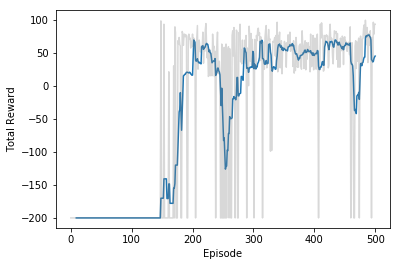

In [23]:
episode_reward_list = [(0, -200.0), (1, -200.0), (2, -200.0), (3, -200.0), (4, -200.0), (5, -200.0), (6, -200.0), (7, -200.0), (8, -200.0), (9, -200.0), (10, -200.0), (11, -200.0), (12, -200.0), (13, -200.0), (14, -200.0), (15, -200.0), (16, -200.0), (17, -200.0), (18, -200.0), (19, -200.0), (20, -200.0), (21, -200.0), (22, -200.0), (23, -200.0), (24, -200.0), (25, -200.0), (26, -200.0), (27, -200.0), (28, -200.0), (29, -200.0), (30, -200.0), (31, -200.0), (32, -200.0), (33, -200.0), (34, -200.0), (35, -200.0), (36, -200.0), (37, -200.0), (38, -200.0), (39, -200.0), (40, -200.0), (41, -200.0), (42, -200.0), (43, -200.0), (44, -200.0), (45, -200.0), (46, -200.0), (47, -200.0), (48, -200.0), (49, -200.0), (50, -200.0), (51, -200.0), (52, -200.0), (53, -200.0), (54, -200.0), (55, -200.0), (56, -200.0), (57, -200.0), (58, -200.0), (59, -200.0), (60, -200.0), (61, -200.0), (62, -200.0), (63, -200.0), (64, -200.0), (65, -200.0), (66, -200.0), (67, -200.0), (68, -200.0), (69, -200.0), (70, -200.0), (71, -200.0), (72, -200.0), (73, -200.0), (74, -200.0), (75, -200.0), (76, -200.0), (77, -200.0), (78, -200.0), (79, -200.0), (80, -200.0), (81, -200.0), (82, -200.0), (83, -200.0), (84, -200.0), (85, -200.0), (86, -200.0), (87, -200.0), (88, -200.0), (89, -200.0), (90, -200.0), (91, -200.0), (92, -200.0), (93, -200.0), (94, -200.0), (95, -200.0), (96, -200.0), (97, -200.0), (98, -200.0), (99, -200.0), (100, -200.0), (101, -200.0), (102, -200.0), (103, -200.0), (104, -200.0), (105, -200.0), (106, -200.0), (107, -200.0), (108, -200.0), (109, -200.0), (110, -200.0), (111, -200.0), (112, -200.0), (113, -200.0), (114, -200.0), (115, -200.0), (116, -200.0), (117, -200.0), (118, -200.0), (119, -200.0), (120, -200.0), (121, -200.0), (122, -200.0), (123, -200.0), (124, -200.0), (125, -200.0), (126, -200.0), (127, -200.0), (128, -200.0), (129, -200.0), (130, -200.0), (131, -200.0), (132, -200.0), (133, -200.0), (134, -200.0), (135, -200.0), (136, -200.0), (137, -200.0), (138, -200.0), (139, -200.0), (140, -200.0), (141, -200.0), (142, -200.0), (143, -200.0), (144, -200.0), (145, -200.0), (146, -200.0), (147, -200.0), (148, 98.0), (149, -200.0), (150, -200.0), (151, -200.0), (152, -200.0), (153, 93.0), (154, -200.0), (155, -200.0), (156, -200.0), (157, -200.0), (158, -200.0), (159, -200.0), (160, -200.0), (161, 21.0), (162, -200.0), (163, -200.0), (164, -200.0), (165, -200.0), (166, -200.0), (167, -200.0), (168, -200.0), (169, 30.0), (170, -200.0), (171, 89.0), (172, 80.0), (173, -200.0), (174, -200.0), (175, -200.0), (176, 68.0), (177, 63.0), (178, 73.0), (179, 62.0), (180, 60.0), (181, -200.0), (182, -200.0), (183, 82.0), (184, 79.0), (185, 61.0), (186, 76.0), (187, 78.0), (188, 74.0), (189, 77.0), (190, 76.0), (191, -200.0), (192, -200.0), (193, 74.0), (194, 78.0), (195, 70.0), (196, 72.0), (197, 57.0), (198, 67.0), (199, 64.0), (200, 78.0), (201, 59.0), (202, 72.0), (203, 57.0), (204, 61.0), (205, -200.0), (206, 54.0), (207, 72.0), (208, 91.0), (209, 25.0), (210, 55.0), (211, 69.0), (212, 59.0), (213, 51.0), (214, 54.0), (215, 60.0), (216, 61.0), (217, 81.0), (218, 34.0), (219, 54.0), (220, 52.0), (221, 85.0), (222, 94.0), (223, 65.0), (224, 42.0), (225, 57.0), (226, 14.0), (227, 17.0), (228, 55.0), (229, 15.0), (230, 48.0), (231, 19.0), (232, 15.0), (233, 78.0), (234, 54.0), (235, 60.0), (236, 14.0), (237, 52.0), (238, -200.0), (239, 49.0), (240, 61.0), (241, 81.0), (242, 18.0), (243, 36.0), (244, 37.0), (245, 17.0), (246, -200.0), (247, -200.0), (248, 63.0), (249, -200.0), (250, -200.0), (251, -200.0), (252, 58.0), (253, -200.0), (254, -200.0), (255, 63.0), (256, -200.0), (257, 42.0), (258, 54.0), (259, 59.0), (260, -200.0), (261, 56.0), (262, 29.0), (263, -200.0), (264, -200.0), (265, 76.0), (266, 83.0), (267, 45.0), (268, 88.0), (269, 32.0), (270, -200.0), (271, 34.0), (272, 84.0), (273, 82.0), (274, -200.0), (275, -200.0), (276, 80.0), (277, 77.0), (278, 93.0), (279, 36.0), (280, 54.0), (281, 33.0), (282, 69.0), (283, 40.0), (284, 48.0), (285, 40.0), (286, 69.0), (287, 34.0), (288, 76.0), (289, -200.0), (290, 57.0), (291, 38.0), (292, 00.0), (293, 90.0), (294, 73.0), (295, 37.0), (296, 79.0), (297, 31.0), (298, 70.0), (299, 44.0), (300, 32.0), (301, -200.0), (302, 70.0), (303, 63.0), (304, 27.0), (305, 76.0), (306, 68.0), (307, 84.0), (308, 87.0), (309, 76.0), (310, 80.0), (311, 38.0), (312, 74.0), (313, 39.0), (314, 66.0), (315, -200.0), (316, 64.0), (317, 66.0), (318, 25.0), (319, 72.0), (320, 84.0), (321, 91.0), (322, 27.0), (323, 38.0), (324, 71.0), (325, 85.0), (326, 69.0), (327, 71.0), (328, -99.0), (329, 27.0), (330, -98.0), (331, 28.0), (332, 67.0), (333, 66.0), (334, 68.0), (335, 73.0), (336, 45.0), (337, 76.0), (338, 29.0), (339, 96.0), (340, 21.0), (341, 76.0), (342, 66.0), (343, 81.0), (344, 27.0), (345, 62.0), (346, 68.0), (347, 18.0), (348, 56.0), (349, 57.0), (350, 56.0), (351, 67.0), (352, 58.0), (353, 64.0), (354, 28.0), (355, 65.0), (356, 57.0), (357, 77.0), (358, 60.0), (359, 62.0), (360, 81.0), (361, 52.0), (362, 64.0), (363, 61.0), (364, 58.0), (365, 29.0), (366, 68.0), (367, 19.0), (368, 29.0), (369, 23.0), (370, 73.0), (371, 60.0), (372, 28.0), (373, 30.0), (374, 28.0), (375, 60.0), (376, 62.0), (377, 63.0), (378, 30.0), (379, 25.0), (380, 83.0), (381, 63.0), (382, 57.0), (383, 26.0), (384, 63.0), (385, 68.0), (386, 24.0), (387, 65.0), (388, 40.0), (389, 59.0), (390, 65.0), (391, 50.0), (392, 59.0), (393, 21.0), (394, 78.0), (395, 29.0), (396, 29.0), (397, 31.0), (398, 76.0), (399, 24.0), (400, 60.0), (401, 72.0), (402, 66.0), (403, 25.0), (404, 71.0), (405, 78.0), (406, 22.0), (407, -200.0), (408, 28.0), (409, 24.0), (410, 93.0), (411, 72.0), (412, 95.0), (413, 77.0), (414, 76.0), (415, 22.0), (416, 24.0), (417, 76.0), (418, 64.0), (419, 74.0), (420, 77.0), (421, 75.0), (422, 75.0), (423, 27.0), (424, 31.0), (425, 77.0), (426, 93.0), (427, 70.0), (428, 72.0), (429, 71.0), (430, 44.0), (431, 33.0), (432, 64.0), (433, 83.0), (434, 82.0), (435, 79.0), (436, 82.0), (437, 40.0), (438, 79.0), (439, 28.0), (440, 54.0), (441, 66.0), (442, 28.0), (443, 72.0), (444, 64.0), (445, 53.0), (446, 75.0), (447, 72.0), (448, 32.0), (449, 72.0), (450, 74.0), (451, 67.0), (452, 67.0), (453, 56.0), (454, 52.0), (455, 65.0), (456, 63.0), (457, 66.0), (458, 47.0), (459, 89.0), (460, -200.0), (461, 24.0), (462, 65.0), (463, 29.0), (464, -94.0), (465, -200.0), (466, -200.0), (467, 60.0), (468, 68.0), (469, 26.0), (470, 66.0), (471, 37.0), (472, 64.0), (473, 72.0), (474, -200.0), (475, 63.0), (476, 75.0), (477, 67.0), (478, 32.0), (479, 70.0), (480, 72.0), (481, 87.0), (482, 92.0), (483, 75.0), (484, 99.0), (485, 84.0), (486, 62.0), (487, 88.0), (488, 35.0), (489, 69.0), (490, 79.0), (491, 61.0), (492, 83.0), (493, 33.0), (494, -200.0), (495, 73.0), (496, 38.0), (497, 96.0), (498, 78.0), (499, 93.0), (500, 93.0)]
eps, rews = np.array(episode_reward_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha = 0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')


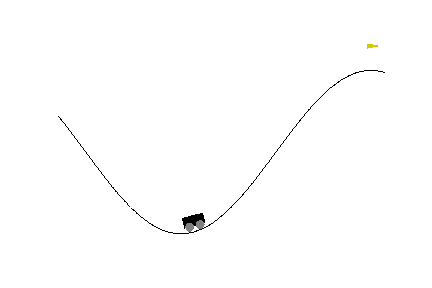

In [33]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

cum_reward = 0

frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render()
display_frames_as_gif(frames)

In [30]:

# Create empty queue
memory = Memory(max_size = memory_size)

# Make a bunch of random actions and store the experiences
state = env.reset()

for _ in range(pretrain_length):
    # Take a random action
    action = env.action_space.sample()
    next_state, _, done, _ = env.step(action)
    modified_reward = compute_modified_reward(next_state)
    
    memory.add((state, action, modified_reward, next_state, done))
    
    if done:
        # Start new episode
        state = env.reset()
    else:
        # Go to next state
        state = next_state